In [1]:
#Imports
!pip install torcheval
!apt install -y ffmpeg
#!pip install ffmpeg-python

import pandas as pd
import numpy as np
import sys
import gc
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing

from torch.autograd import Variable 
from tqdm import tqdm
import glob
import random
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torcheval
import timm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torcheval.metrics import BinaryAccuracy


from torch import nn
from sklearn.metrics import matthews_corrcoef
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import math

from timm.scheduler import CosineLRScheduler




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 7.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


## **NFL contact detection 2023**

My inference notebook for scoring model: https://www.kaggle.com/code/gumm4n/nfl-inference

*Notebook based on public 2,5D CNN inference notebook made by* **zzy**. *Notebook: https://www.kaggle.com/code/zzy990106/nfl-2-5d-cnn-baseline-inference*


#### Results: 
* My score: 0.52(Matthews correlation cofficient, from -1 to 1, where 1 is perfect 0 is no correct and 0 is random guess)
* Winning score was 0.79

#### *Task:* 
The goal of this competition is to detect external contact experienced by players during an NFL football game. You will use video and player tracking data to identify moments with contact to help improve player safety.
Submissions are evaluated on Matthews Correlation Coefficient between the predicted and actual contact events.

<img align=left src = "attachment:image's http://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F644036%2F65cd663d2c823043b36ecda6c93c1304%2Fcontact-example.gif?generation=1670265252697886&alt=media" width="500">



![](http://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F644036%2F65cd663d2c823043b36ecda6c93c1304%2Fcontact-example.gif?generation=1670265252697886&alt=media)

#### **Data:**
**Videos**
Each play has four associated videos. Two videos, showing a sideline and endzone view, are time synced and aligned with each other. Additionally, an All29 view is provided but not guaranteed to be time synced. The training set videos are in train/ with corresponding labels in train_labels.csv, while the videos for which you must predict are in the test/ folder.

**Tracking data**
Tracking data is provided with player tracking data for every 6th frame. The data contains postitional data as well as for example velocity, accleration and orientation.

**Helmet data**
An imperfect dataset of helmet object detections for all videos exists. Helmet position for each player each frame exists. Data is based on previous Kaggle helmet detection competitions.


#### **Model:**
Main idea was to try old school video classification with (2D CNN + lstm) concatenated with the feature data to be able to understand the temporal video data.

**Input**
* Tracking features, original data for both players + added distance between players -> MLP
* Images for each frame, both sideline and endzone view. -> CNN -> LSTM

**Output**
Given 2 player id's(or 1 player and G(ground)) the model should be able to tell if there is contact or not, 1 or 0.
A threshold of 2m was chosen as a maximum distance possibility for possible contact. Thus all inputs where distance between players > 2 was set as 0.

**2D CNN input**

Two channels were used: One channel with the image centered around the two bounding boxes of the players, and the other channel with only the bounding boxes as well as some features to help the CNN to find where the area of interest are.

*Image channel:*
Due to the players being different size for different videos/frames, one could make use of the size of the helmet bounding box to estimate a area of interest.
* Images were cropped to: max(average bbox width, average bbox height) * 4 (centered in the mean coordinate of the two bboxes).
* Then images were resized to 256x256.

     ![](https://i.ibb.co/Kwv2P7C/nfl-channel1.png)    


*Feature channel:*
* Draw the bounding boxes on blank 256x256 to help the CNN where to look in the image.
* Naively thinking the distance between the players should be the most important feature to classify contact. Thus the color of the bboxes could be changed depending on the distance between the players.
    * Player v ground: *color = 100*
    * Player1 v player2: *color = 255-50*distance* (Ranging from 155(distance = 2) to 255(distance = 0))
    
   ![](https://i.ibb.co/YtD1xLb/nfl-channel2.png)    

**LSTM**
Endzone, sideline concatenated.
A sequence of 5 frames each with a time step of 12 frames were used as input into the LSTM.


Output from LSTM model were concatenated with the tracking data features to get the final output as the probability of the specific frame having concatct between p1 and p2.


**Data**
Regular data augmentation were done.
Given the specific frame a randomized frame +-3 frames apart were used to randomize training.
One frame were only used once during training, thus each 6th frame were used. This helped overfitting and minimized the training data alot.

#### *Method:*
Striding training data
Augmentations

#### *Test:*
No real parameter testing was done due to no availble offline GPU so testing was limited to Kaggle GPU quota. Model is more a conccept and made for learning.

#### *Ideas for improvement*
* Split PP and PG. Very different data. Features only of for 1 player, no distance, no 2 boxes and so on. Instead of separating by pixel values and setting features to negative, split the two problems.
* 3D CNN work instead of LSTM, reached better scores in other competitions.
* Maybe use a separate XGB/LGBM model for the tracking data instead of MLP. Then do ensemble after DL model.


#### *After project note*
Project was finished after competition deadline for interests and learning purposes. Given the focus was not completely on the result the model wasn't optimized and the parameters wasn't completely tuned. In this project I limited myself to use just the given data. Most teams scoring a better results used public rankings of the teams which was available online. The public rankings were probably far superior to the "naive" handmade conference ranking in this model.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Config
folder = "/kaggle/input/nfl-player-contact-detection/"


In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2].astype("int")
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    df["game_key"] = df["contact_id"].str.split("_").str[-5].astype("int")
    df["play_id"] = df["contact_id"].str.split("_").str[-4].astype("int")
    return df


In [5]:
train_labels = expand_contact_id(pd.read_csv(folder+"/train_labels.csv")[["contact_id","contact"]])
train_tracking = pd.read_csv(folder+"/train_player_tracking.csv")
train_helmets = pd.read_csv(folder+"/train_baseline_helmets.csv")
train_video_metadata = pd.read_csv(folder+"/train_video_metadata.csv")

In [6]:
#istället för att rensa train_helmets så rensa train_tracking

In [7]:
label_index = train_labels[['game_key', 'play_id',  'nfl_player_id_1', 'step']]
label_index['frame'] = (label_index['step']/10*59.94+5*59.94).astype('int')+1
label_index = label_index[['game_key', 'play_id',  'nfl_player_id_1', 'frame']].reset_index(drop = False)

/tmp/ipykernel_29/450451848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_index['frame'] = (label_index['step']/10*59.94+5*59.94).astype('int')+1


In [8]:
train_helmet = train_helmets[['game_key', 'play_id',  'nfl_player_id', 'frame', 'view']]
view_list = (train_helmet.groupby(['game_key', 'play_id',  'nfl_player_id', 'frame']).sum())
#sideline = view_list[view_list['view'] == 'Sideline'].reset_index()
#endzone = view_list[view_list['view'] == 'Endzone'].reset_index()
all_views = view_list[view_list['view'] == 'EndzoneSideline'].reset_index()

In [9]:
df_index = label_index.merge(all_views, how = 'inner', right_on = ['game_key', 'play_id',  'nfl_player_id', 'frame'], left_on = ['game_key', 'play_id',  'nfl_player_id_1', 'frame'])
#sidelineindex = label_index.merge(sideline, how = 'inner', right_on = ['game_key', 'play_id',  'nfl_player_id', 'frame'], left_on = ['game_key', 'play_id',  'nfl_player_id_1', 'frame'])

In [10]:
index_list = df_index['index'].to_list()


In [11]:
#sorted_labels = train_labels[train_lables[index_list]]# Step 2
#sorted_labels = sorted_labels.drop(end_index, axis=0) # Step 2
sorted_labels = train_labels.iloc[index_list]# Step 2


In [12]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]


train, feature_cols = create_features(sorted_labels, train_tracking, use_cols=use_cols)
train_filtered = train.query('not distance > 2').reset_index(drop=True)
train_filtered['frame'] = (train_filtered['step']/10*59.94+5*59.94).astype('int')+1


In [13]:
train_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,x_position_1,y_position_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,58168,3392,41.90,20.08,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,58168,3392,41.90,20.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,58168,3392,39.59,17.07,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,58168,3392,39.59,17.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,58168,3392,41.93,30.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221359,58582_003121_90_45287_G,0,58582_003121,90,45287,G,58582,3121,62.95,42.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,840
221360,58582_003121_90_46155_G,0,58582_003121,90,46155,G,58582,3121,62.39,40.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,840
221361,58582_003121_90_47872_G,0,58582_003121,90,47872,G,58582,3121,62.58,43.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,840
221362,58582_003121_90_52493_G,0,58582_003121,90,52493,G,58582,3121,65.01,38.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,840


In [14]:
del train, train_labels, train_tracking
gc.collect()

23

In [15]:
#G_data = train_filtered[train_filtered['nfl_player_id_2'] == 'G']
#train_filtered = train_filtered[train_filtered['nfl_player_id_2'] != 'G']

#G_data.index = range(len(G_data.index))
#train_filtered.index = range(len(train_filtered.index))

In [16]:
scaled_features = train_filtered.copy()
features = scaled_features[feature_cols]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[feature_cols] = features
train_filtered = scaled_features

del scaled_features
gc.collect()

0

In [17]:
#G_data = G_data[:200]
#train_data = []
train_filtered.sort_values(by=['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'frame']).reset_index(drop = True)
train_filtered = train_filtered.iloc[5::6,:].reset_index(drop = True)


#for i in range(0,11):
 #   train_data.append(train_filtered[13200*i:13200*(i+1)])


In [18]:
train_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,game_key,play_id,x_position_1,y_position_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_38567_45695,0,58168_003392,0,38567,45695,58168,3392,0.359375,0.372496,...,0.410639,0.085487,0.078431,0.506528,0.260403,0.164103,0.561828,0.947326,0.0,300
1,58168_003392_0_38590_G,0,58168_003392,0,38590,G,58168,3392,0.359075,0.458347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,300
2,58168_003392_0_41944_G,0,58168_003392,0,41944,G,58168,3392,0.371620,0.419714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,300
3,58168_003392_0_43854_G,0,58168_003392,0,43854,G,58168,3392,0.371544,0.323370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,300
4,58168_003392_0_46445_G,0,58168_003392,0,46445,G,58168,3392,0.359150,0.343879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36889,58582_003121_88_45287_47872,0,58582_003121,88,45287,47872,58582,3121,0.530048,0.732750,...,0.761920,0.132207,0.137255,0.390966,0.340658,0.060513,0.445699,0.537176,0.0,828
36890,58582_003121_89_36712_G,0,58582_003121,89,36712,G,58582,3121,0.549730,0.646264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,834
36891,58582_003121_89_47872_G,0,58582_003121,89,47872,G,58582,3121,0.525841,0.744833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,834
36892,58582_003121_90_39971_G,1,58582_003121,90,39971,G,58582,3121,0.511944,0.738792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,840


In [19]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=0.3),
    #A.RandomGamma(p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [20]:
video2helmets = {}
train_helmets_new = train_helmets.set_index('video')
for video in tqdm(train_helmets.video.unique()):
    video2helmets[video] = train_helmets_new.loc[video].reset_index(drop=True)
    
del train_helmets, train_helmets_new
gc.collect()


100%|██████████| 481/481 [01:13<00:00,  6.52it/s]


0

In [21]:
video2frames = {}

for game_play in tqdm(train_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f"/kaggle/input/nfl-contact-extracted-train-frames/content/work/frames/train/{video}*"))))

100%|██████████| 240/240 [05:52<00:00,  1.47s/it]


In [22]:

class MyDataset_LSTM(Dataset):
    def __init__(self, df, aug=train_aug):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.contact_id = df.contact_id.values
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):  
        time_size = 12
        sequence = 5    #number of frames in lstm sequence
        frame = self.frame[idx]
        frame_idx = frame
        
        
        if self.aug == train_aug:
            frame = frame + random.randint(-6, 6)
        frame_diff = frame - frame_idx
        players = []
        
        #??
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
   
       
        imgs_arr = []
        
        for f in range(frame-((sequence//2)*time_size), frame+((sequence//2)*time_size)+1, time_size):
            imgs = []

            for view in ['Endzone', 'Sideline']:

                video = self.game_play[idx] + f'_{view}.mp4'
                
                tmp = video2helmets[video]           
                tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])         
                tmp = tmp[tmp['frame'] == f]
                
                bboxes = []
                img_size = 0
                if len(tmp['left']):
                  
                    for i in range(len(tmp.index)):
                        
                        x = tmp['left'].tolist()[i]
                        w = tmp['width'].tolist()[i]
                        y = tmp['top'].tolist()[i]
                        h = tmp['height'].tolist()[i]
                        if math.isfinite(x):
                            bboxes.append([x, w, y, h])
                            img_size = max([img_size, w, h])
                            
                        
                        
                    img_helmet = np.zeros((720,1280), dtype=np.float32)  
                    if len(tmp) == 2:
                        
                        
                        #df_dist = self.df[(self.df['game_play'] == self.game_play) &
                        #                   (self.df['nfl_player_id_1'] == str(players[0]))  & (self.df['nfl_player_id_2'] == str(players[1]))]
                        #closest_frame = min(df_dist.frame.values, key=lambda x:abs(x-(f-frame_diff)))
                        dist = self.df.distance[idx]

                        if math.isfinite(dist):
                            color_dist = int(156+(100-(100*dist)))
                            
                        else:
                            color_dist = 100
                           
                        color = (color_dist, 0, 0)                        
                        
                    else:
                        color = (100, 0, 0)
                    
                    
                    for i in range(len(tmp)):
                        
                        start_point = (bboxes[i][0], bboxes[i][2])
                        end_point = (bboxes[i][0] +  bboxes[i][1], bboxes[i][2] + bboxes[i][3])
                        

                        img_helmet = cv2.rectangle(img_helmet, start_point, end_point, color, thickness =-1)
                    
                    
                    img_new = np.zeros((256, 256), dtype=np.float32)         
                    img = cv2.imread(f"/kaggle/input/nfl-contact-extracted-train-frames/content/work/frames/train/{video}_{f:04d}.jpg", 0)

                    
                    if len(tmp) == 2:  
                        x = ((bboxes[0][0] + bboxes[1][0])/2) + ((bboxes[0][1] + bboxes[1][1])/4)
                        y = ((bboxes[0][2] + bboxes[1][2])/2) + ((bboxes[0][3] + bboxes[1][3])/4)   
                    else: 
                        x = bboxes[0][0] + (bboxes[0][1]/2)
                        y = bboxes[0][2] + (bboxes[0][3]/2)
                   
                    if x < img_size*4:
                            x = img_size * 4
                    if y < img_size * 4:
                            y = img_size * 4
                 
                    if img.size == 0:      
                        img_h = np.zeros((256,256), dtype=np.float32) 
                        img_new = np.zeros((256, 256), dtype=np.float32) 
                        
                    else:
                        
                        
                        img = img[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                       
                        
                        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
                        
                        img_new[:img.shape[0], :img.shape[1]] = img 
                        
                        #img = img[int(y)-128:int(y)+128,int(x)-128:int(x)+128].copy()
                        img_helmet = img_helmet[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                        img_helmet = cv2.resize(img_helmet, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

                      
                        



                        img_h = np.zeros((256, 256), dtype=np.float32)         
                        img_h[:img_helmet.shape[0], :img_helmet.shape[1]] = img_helmet               
                             
                else:
                    
                    img_h = np.zeros((256,256), dtype=np.float32) 
                    img_new = np.zeros((256, 256), dtype=np.float32)   


                imgs.append(img_new)
                imgs.append(img_h)
                #plt.imshow(imgs[1])
                #plt.show()
                
                
            imgs_arr.append(imgs)
       
                
        feature = np.float32(self.feature[idx])
         
   
 
        imga = np.array(imgs_arr)

        b, c, h, w = imga.shape
        imga = imga.reshape(b//b, c*sequence, h, w)
        imga = np.squeeze(imga)
        imga = imga.transpose(1,2,0)
    
        imga = self.aug(image=imga)["image"]
        label = np.float32(self.df.contact.values[idx])

        
        return imga, feature, label
    


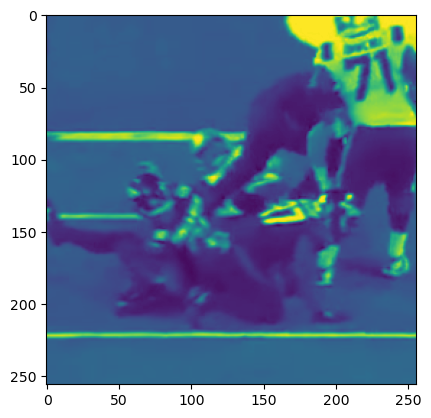

(torch.Size([20, 256, 256]),
 array([0.8472806 , 0.46470588, 0.00473934, 0.        , 0.83543986,
        0.37403816, 0.08717949, 0.4392073 , 0.8508058 , 0.48751217,
        0.04970179, 0.04901961, 0.17009278, 0.1657592 , 0.03897436,
        0.49462366, 0.5038045 , 0.        ], dtype=float32),
 0.0)

In [23]:
img, feature, label = MyDataset_LSTM(train_filtered, valid_aug)[15900]
plt.imshow(img.permute(1,2,0)[:,:,0])
plt.rcParams["figure.figsize"] = 3,3
plt.savefig('nfl_18.png')

plt.show()
img.shape, feature, label





In [24]:
sum(train_filtered['G_flug'])

21041.0

In [25]:
train_filtered = train_filtered[:8000]

In [ ]:
print(sum(train_filtered['G_flug']))

In [26]:
print(sum(train_filtered['contact']))

902


In [27]:
class Model(nn.Module):
    def __init__(self, num_layers = 1, input_size = 256, hidden_size = 64, seq_length = 5):
        super(Model, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        #efficientnet_b1
        self.backbone = timm.create_model('resnet50', pretrained=True, num_classes=128, in_chans=2)
        
                
        self.mlp = nn.Sequential(
            nn.Linear(18, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.2),
         
        )

        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_lstm = nn.Linear(hidden_size, 128) 
        
        self.softmax = nn.Softmax()
        self.fc = nn.Linear(128+32, 1)

    def forward(self, img, x):
        
        b, c, h, w = img.shape   
        img = img.reshape(b*(c//2),c//(c//2), h, w)
        img = self.backbone(img)
        img = img.reshape(b,self.seq_length, -1)


        h_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #internal state
        
        #self.lstm.flatten_parameters()


        output, (hn, cn) = self.lstm(img, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.softmax(hn)
        out = self.fc_lstm(out)
        #out = self.softmax(out)
    
        feature = self.mlp(x)

        #feature = torch.transpose(feature, 0, 1)
        y = self.fc(torch.cat([out, feature], dim=1))
        return y

In [28]:
train_data,val_data = train_test_split(train_filtered,test_size=0.1, random_state=42,stratify = train_filtered['contact'])
train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)
batch_size = 16

train_set = MyDataset_LSTM(train_data, train_aug)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_set = MyDataset_LSTM(val_data, valid_aug)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

model = Model()

model= nn.DataParallel(model)
model.to(device)
#model.backbone.requires_grad_(False)

metric = BinaryAccuracy(threshold = 0.0)
val_metric = BinaryAccuracy(threshold = 0.0)


criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 


In [29]:
from timm.scheduler import CosineLRScheduler
#train_set = MyDataset_LSTM(train_data[0], train_aug)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    


In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay= 1e-6,)
nbatch = len(train_loader)
warmup = 1* nbatch
nsteps = 5 * nbatch 


scheduler = CosineLRScheduler(optimizer,warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,t_initial=(nsteps - warmup), lr_min=1e-6)                


In [31]:
best_loss = 0
for epoch in range(5):  # loop over the dataset multiple times
    i = 0
    
    
    #train_set = MyDataset_LSTM(train_data[epoch%9], train_aug)
    #train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    
    
    
    model.train()
    for batch,(img, feature, label) in tqdm(enumerate(train_loader),total = len(train_loader)):
        
        loss_sum = 0.0
        n_sum = 0
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        n = label.size(0)

        
        output = model(img, feature).reshape(-1)
   
        optimizer.zero_grad()
        metric = BinaryAccuracy(threshold = 0.0)

        metric.update(output.cpu(), label.cpu())
        
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        scheduler.step(epoch * nbatch + batch + 1)


        train_loss = loss.item()
        loss_sum += n * train_loss
        n_sum += n

        nn.utils.clip_grad_norm_(model.parameters(), 1000)

        if batch % 10 == 9:    # print every 2000 mini-batches
            loss_train = loss_sum / n_sum
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {loss_train:.3f}')
            
        if batch % 100 == 9:  
            print(output)
            print(label)
        del label, img, feature, output
        gc.collect()
    
        n = 0
        score = 0.0
    print('Validating model')
    model.eval()
    test_loss_sum = 0.0
    test_n_sum = 0
    test_n = 0
    #m_score = 0
    for batch,(img, feature, label) in tqdm(enumerate(val_loader),total = len(val_loader)):
        test_n = label.size(0)
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            output = model(img, feature).reshape(-1)
            loss = criterion(output, label)
        test_loss = loss.item()
        test_loss_sum += test_n * test_loss
        test_n_sum += test_n
        #m_score += matthews_corrcoef(label.cpu(), output.cpu())
        i += 1
        metric = BinaryAccuracy(threshold = 0.0)
        
        
        

        metric.update(output.cpu(), label.cpu())
        score = score + metric.compute()
        n = n + 1


        del label, img, feature, output
        gc.collect()
    #m_score = m_score/i
    val_loss = test_loss_sum / test_n_sum
    val_score = score/n
    
    if val_loss < best_loss:
        best_loss = val_loss
        # Save model
        ofilename = 'nfl_model.pytorch'
        torch.save(model.state_dict(), ofilename)
        print(ofilename, 'written')
    
    
    #print(f'MCC score: {m_score}')
    print(f'Validation accuracy: {val_score}')
    print(f'Validation loss: {val_loss}')
    
    

  0%|          | 0/450 [00:00<?, ?it/s]/tmp/ipykernel_29/1383870055.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(hn)
  2%|▏         | 9/450 [00:34<16:38,  2.27s/it]  

[1,    10] loss: 0.729
tensor([-0.0037,  0.1832,  0.1150,  0.0633,  0.1258,  0.3676, -0.0438,  0.0960,
        -0.0743,  0.0758,  0.2004, -0.0707,  0.1686, -0.0608,  0.0677,  0.1448],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


  4%|▍         | 19/450 [01:00<18:34,  2.58s/it]

[1,    20] loss: 0.715


  6%|▋         | 29/450 [01:25<17:09,  2.45s/it]

[1,    30] loss: 0.713


  9%|▊         | 39/450 [01:52<16:43,  2.44s/it]

[1,    40] loss: 0.709


 11%|█         | 49/450 [02:17<16:24,  2.46s/it]

[1,    50] loss: 0.697


 13%|█▎        | 59/450 [02:41<15:38,  2.40s/it]

[1,    60] loss: 0.672


 15%|█▌        | 69/450 [03:05<14:45,  2.32s/it]

[1,    70] loss: 0.638


 18%|█▊        | 79/450 [03:29<14:22,  2.32s/it]

[1,    80] loss: 0.582


 20%|█▉        | 89/450 [03:54<13:59,  2.33s/it]

[1,    90] loss: 0.619


 22%|██▏       | 99/450 [04:19<14:08,  2.42s/it]

[1,   100] loss: 0.551


 24%|██▍       | 109/450 [04:45<14:34,  2.57s/it]

[1,   110] loss: 0.499
tensor([-0.5140, -0.4363, -0.5017, -0.4181, -0.7008, -0.7051, -0.4090, -0.5736,
        -0.3975, -0.5412, -0.5802, -0.4585, -0.5620, -0.4224, -0.4276, -0.4584],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 26%|██▋       | 119/450 [05:08<12:33,  2.28s/it]

[1,   120] loss: 0.495


 29%|██▊       | 129/450 [05:32<12:36,  2.36s/it]

[1,   130] loss: 0.572


 31%|███       | 139/450 [05:57<11:55,  2.30s/it]

[1,   140] loss: 0.425


 33%|███▎      | 149/450 [06:20<11:52,  2.37s/it]

[1,   150] loss: 0.560


 35%|███▌      | 159/450 [06:44<11:21,  2.34s/it]

[1,   160] loss: 0.638


 38%|███▊      | 169/450 [07:07<10:56,  2.34s/it]

[1,   170] loss: 0.485


 40%|███▉      | 179/450 [07:31<10:39,  2.36s/it]

[1,   180] loss: 0.464


 42%|████▏     | 189/450 [07:55<10:24,  2.39s/it]

[1,   190] loss: 0.303


 44%|████▍     | 199/450 [08:19<09:38,  2.30s/it]

[1,   200] loss: 0.305


 46%|████▋     | 209/450 [08:44<09:44,  2.43s/it]

[1,   210] loss: 0.364
tensor([-1.4779, -1.5199, -1.3380, -1.4413, -1.8441, -1.8818, -1.9587, -1.3981,
        -1.2808, -1.7632, -1.9182, -1.9664, -1.3327, -1.6944, -1.3459, -1.4660],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 49%|████▊     | 219/450 [09:09<09:04,  2.36s/it]

[1,   220] loss: 0.172


 51%|█████     | 229/450 [09:34<09:01,  2.45s/it]

[1,   230] loss: 0.483


 53%|█████▎    | 239/450 [09:58<08:01,  2.28s/it]

[1,   240] loss: 0.390


 55%|█████▌    | 249/450 [10:22<07:52,  2.35s/it]

[1,   250] loss: 0.448


 58%|█████▊    | 259/450 [10:46<07:18,  2.30s/it]

[1,   260] loss: 0.153


 60%|█████▉    | 269/450 [11:10<06:59,  2.32s/it]

[1,   270] loss: 0.737


 62%|██████▏   | 279/450 [11:33<06:13,  2.19s/it]

[1,   280] loss: 0.489


 64%|██████▍   | 289/450 [11:57<06:01,  2.25s/it]

[1,   290] loss: 0.354


 66%|██████▋   | 299/450 [12:20<05:40,  2.26s/it]

[1,   300] loss: 0.534


 69%|██████▊   | 309/450 [12:44<05:39,  2.41s/it]

[1,   310] loss: 0.172
tensor([-2.6922, -1.8247, -1.5528, -1.9923, -2.3021, -1.3749, -1.2071, -1.7659,
        -1.6996, -1.5624, -1.7030, -1.3552, -1.5920, -1.4177, -1.3778, -2.3110],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 71%|███████   | 319/450 [13:07<04:48,  2.20s/it]

[1,   320] loss: 0.333


 73%|███████▎  | 329/450 [13:30<04:36,  2.28s/it]

[1,   330] loss: 0.225


 75%|███████▌  | 339/450 [13:54<04:08,  2.24s/it]

[1,   340] loss: 0.350


 78%|███████▊  | 349/450 [14:17<03:56,  2.35s/it]

[1,   350] loss: 0.360


 80%|███████▉  | 359/450 [14:40<03:27,  2.28s/it]

[1,   360] loss: 0.375


 82%|████████▏ | 369/450 [15:03<02:58,  2.20s/it]

[1,   370] loss: 0.292


 84%|████████▍ | 379/450 [15:26<02:42,  2.29s/it]

[1,   380] loss: 0.206


 87%|████████▋ | 390/450 [15:50<02:21,  2.36s/it]

[1,   390] loss: 0.362


 89%|████████▊ | 399/450 [16:10<01:50,  2.16s/it]

[1,   400] loss: 0.220


 91%|█████████ | 409/450 [16:33<01:31,  2.23s/it]

[1,   410] loss: 0.435
tensor([-1.5319, -1.3491, -1.7269, -0.8626, -1.9206, -1.7294, -2.0128, -2.0128,
        -1.5702, -0.9462, -1.6650, -2.9040, -2.2831, -1.5946, -2.7757, -2.6174],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 93%|█████████▎| 419/450 [16:56<01:11,  2.32s/it]

[1,   420] loss: 0.205


 95%|█████████▌| 429/450 [17:18<00:45,  2.15s/it]

[1,   430] loss: 0.181


 98%|█████████▊| 439/450 [17:41<00:23,  2.17s/it]

[1,   440] loss: 0.341


100%|█████████▉| 449/450 [18:03<00:02,  2.01s/it]

[1,   450] loss: 0.155


100%|██████████| 450/450 [18:05<00:00,  2.41s/it]


Validating model


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]

Validation accuracy: 0.887499988079071
Validation loss: 0.266660241484642



  2%|▏         | 9/450 [00:23<16:51,  2.29s/it]

[2,    10] loss: 0.314
tensor([-3.1906, -2.9515, -3.1992, -0.8729, -0.5139, -2.0819, -1.8449, -2.3174,
        -1.1195, -2.4464, -2.7842, -2.3769, -3.3213, -2.3552, -3.3786, -2.4357],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  4%|▍         | 19/450 [00:45<16:43,  2.33s/it]

[2,    20] loss: 0.216


  6%|▋         | 29/450 [01:09<17:54,  2.55s/it]

[2,    30] loss: 0.311


  9%|▊         | 39/450 [01:32<16:53,  2.47s/it]

[2,    40] loss: 0.164


 11%|█         | 49/450 [01:56<16:19,  2.44s/it]

[2,    50] loss: 0.385


 13%|█▎        | 59/450 [02:21<16:52,  2.59s/it]

[2,    60] loss: 0.352


 16%|█▌        | 70/450 [02:49<15:35,  2.46s/it]

[2,    70] loss: 0.157


 18%|█▊        | 79/450 [03:11<15:46,  2.55s/it]

[2,    80] loss: 0.318


 20%|█▉        | 89/450 [03:35<14:04,  2.34s/it]

[2,    90] loss: 0.736


 22%|██▏       | 99/450 [04:00<14:17,  2.44s/it]

[2,   100] loss: 0.588


 24%|██▍       | 109/450 [04:24<13:58,  2.46s/it]

[2,   110] loss: 0.269
tensor([-2.1183, -2.5056, -2.0927, -2.4192, -0.3746, -2.8210, -2.9304, -2.6524,
        -2.5135, -2.9097, -2.2910, -1.5720, -2.7971, -2.3973, -2.3993, -2.9355],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 26%|██▋       | 119/450 [04:50<14:34,  2.64s/it]

[2,   120] loss: 0.142


 29%|██▊       | 129/450 [05:15<15:02,  2.81s/it]

[2,   130] loss: 0.283


 31%|███       | 139/450 [05:39<13:00,  2.51s/it]

[2,   140] loss: 0.130


 33%|███▎      | 149/450 [06:04<12:45,  2.54s/it]

[2,   150] loss: 0.196


 35%|███▌      | 159/450 [06:30<12:38,  2.61s/it]

[2,   160] loss: 0.402


 38%|███▊      | 169/450 [06:56<13:45,  2.94s/it]

[2,   170] loss: 0.202


 40%|███▉      | 179/450 [07:20<11:17,  2.50s/it]

[2,   180] loss: 0.091


 42%|████▏     | 189/450 [07:44<10:23,  2.39s/it]

[2,   190] loss: 0.065


 44%|████▍     | 199/450 [08:08<10:12,  2.44s/it]

[2,   200] loss: 0.307


 46%|████▋     | 209/450 [08:31<09:25,  2.35s/it]

[2,   210] loss: 0.152
tensor([ 0.0412, -3.0636, -2.7957, -3.2451, -3.2906, -0.0377, -3.4298, -2.2224,
        -2.9375, -2.9578,  0.8330, -2.7587, -2.8762, -2.8121, -2.9660, -2.5180],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 49%|████▊     | 219/450 [08:53<08:38,  2.24s/it]

[2,   220] loss: 0.250


 51%|█████     | 229/450 [09:16<08:21,  2.27s/it]

[2,   230] loss: 0.103


 53%|█████▎    | 239/450 [09:40<08:40,  2.47s/it]

[2,   240] loss: 0.102


 55%|█████▌    | 249/450 [10:03<08:27,  2.53s/it]

[2,   250] loss: 0.602


 58%|█████▊    | 259/450 [10:27<07:36,  2.39s/it]

[2,   260] loss: 0.157


 60%|█████▉    | 269/450 [10:50<07:09,  2.37s/it]

[2,   270] loss: 0.142


 62%|██████▏   | 279/450 [11:13<06:49,  2.39s/it]

[2,   280] loss: 0.174


 64%|██████▍   | 289/450 [11:36<06:19,  2.36s/it]

[2,   290] loss: 0.055


 66%|██████▋   | 299/450 [12:00<05:50,  2.32s/it]

[2,   300] loss: 0.337


 69%|██████▊   | 309/450 [12:23<05:22,  2.29s/it]

[2,   310] loss: 0.198
tensor([-2.5538, -3.5890, -3.1875, -1.1653, -2.8332, -3.2122, -3.5119, -2.7308,
        -2.6461, -2.4885, -2.3517, -0.3966, -0.4258, -2.7751, -2.9961, -3.4456],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 71%|███████   | 319/450 [12:46<05:16,  2.42s/it]

[2,   320] loss: 0.155


 73%|███████▎  | 329/450 [13:08<04:28,  2.22s/it]

[2,   330] loss: 0.306


 75%|███████▌  | 339/450 [13:31<04:07,  2.23s/it]

[2,   340] loss: 0.277


 78%|███████▊  | 349/450 [13:54<03:45,  2.23s/it]

[2,   350] loss: 0.333


 80%|███████▉  | 359/450 [14:17<03:55,  2.59s/it]

[2,   360] loss: 0.349


 82%|████████▏ | 369/450 [14:41<03:14,  2.40s/it]

[2,   370] loss: 0.128


 84%|████████▍ | 379/450 [15:06<02:56,  2.49s/it]

[2,   380] loss: 0.237


 86%|████████▋ | 389/450 [15:30<02:30,  2.47s/it]

[2,   390] loss: 0.196


 89%|████████▊ | 399/450 [15:54<02:10,  2.55s/it]

[2,   400] loss: 0.210


 91%|█████████ | 409/450 [16:17<01:37,  2.39s/it]

[2,   410] loss: 0.364
tensor([-3.9704, -2.3972, -3.4794, -2.6532, -2.6003, -2.8099, -2.9565,  0.2383,
        -2.1711, -2.8019, -2.3224, -0.3099, -3.4158, -2.9585, -2.3480, -2.3533],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 93%|█████████▎| 419/450 [16:41<01:14,  2.39s/it]

[2,   420] loss: 0.308


 95%|█████████▌| 429/450 [17:05<00:51,  2.45s/it]

[2,   430] loss: 0.348


 98%|█████████▊| 439/450 [17:29<00:27,  2.52s/it]

[2,   440] loss: 0.305


100%|██████████| 450/450 [17:53<00:00,  2.10s/it]

[2,   450] loss: 0.542


100%|██████████| 450/450 [17:54<00:00,  2.39s/it]

Validating model



100%|██████████| 50/50 [01:33<00:00,  1.86s/it]

Validation accuracy: 0.9225000143051147
Validation loss: 0.22861753210425376



  2%|▏         | 9/450 [00:23<17:28,  2.38s/it]

[3,    10] loss: 0.391
tensor([-2.4992, -3.7100, -1.9678,  0.9516, -2.5457,  0.2265, -2.4988, -2.3695,
        -3.2631, -2.7815,  0.9903, -2.7798, -0.0239, -3.1872, -2.1427,  1.1041],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  4%|▍         | 19/450 [00:50<18:18,  2.55s/it]

[3,    20] loss: 0.312


  6%|▋         | 29/450 [01:13<17:31,  2.50s/it]

[3,    30] loss: 0.426


  9%|▊         | 39/450 [01:36<15:14,  2.23s/it]

[3,    40] loss: 0.075


 11%|█         | 49/450 [02:00<15:48,  2.37s/it]

[3,    50] loss: 0.321


 13%|█▎        | 59/450 [02:23<15:24,  2.37s/it]

[3,    60] loss: 0.150


 15%|█▌        | 69/450 [02:46<15:37,  2.46s/it]

[3,    70] loss: 0.270


 18%|█▊        | 79/450 [03:09<14:59,  2.42s/it]

[3,    80] loss: 0.296


 20%|█▉        | 89/450 [03:33<13:56,  2.32s/it]

[3,    90] loss: 0.243


 22%|██▏       | 99/450 [03:56<13:25,  2.30s/it]

[3,   100] loss: 0.138


 24%|██▍       | 109/450 [04:19<13:25,  2.36s/it]

[3,   110] loss: 0.445
tensor([-3.0060,  0.8110, -2.2600,  0.6728, -2.5305, -3.6665, -3.3845, -3.6849,
        -3.5381, -1.6179, -1.1625, -4.1426,  0.9929, -3.2023, -2.8879, -3.4296],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 26%|██▋       | 119/450 [04:43<13:05,  2.37s/it]

[3,   120] loss: 0.491


 29%|██▊       | 129/450 [05:06<12:52,  2.41s/it]

[3,   130] loss: 0.348


 31%|███       | 139/450 [05:31<12:57,  2.50s/it]

[3,   140] loss: 0.529


 33%|███▎      | 150/450 [05:57<13:06,  2.62s/it]

[3,   150] loss: 0.378


 35%|███▌      | 159/450 [06:18<11:12,  2.31s/it]

[3,   160] loss: 0.194


 38%|███▊      | 169/450 [06:43<11:36,  2.48s/it]

[3,   170] loss: 0.306


 40%|███▉      | 179/450 [07:09<12:11,  2.70s/it]

[3,   180] loss: 0.105


 42%|████▏     | 189/450 [07:34<11:45,  2.70s/it]

[3,   190] loss: 0.128


 44%|████▍     | 199/450 [07:58<10:32,  2.52s/it]

[3,   200] loss: 0.149


 46%|████▋     | 209/450 [08:23<10:36,  2.64s/it]

[3,   210] loss: 0.152
tensor([-2.9199, -1.6852, -2.8295,  0.9663, -2.6463, -2.6622, -2.2380, -3.1928,
        -2.1922, -2.3096, -3.1617, -1.8895, -2.5828, -3.1444, -2.8800, -3.2793],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 49%|████▊     | 219/450 [08:47<09:22,  2.43s/it]

[3,   220] loss: 0.353


 51%|█████     | 229/450 [09:12<09:14,  2.51s/it]

[3,   230] loss: 0.152


 53%|█████▎    | 240/450 [09:36<07:42,  2.20s/it]

[3,   240] loss: 0.118


 55%|█████▌    | 249/450 [09:58<07:44,  2.31s/it]

[3,   250] loss: 0.207


 58%|█████▊    | 259/450 [10:21<07:30,  2.36s/it]

[3,   260] loss: 0.296


 60%|█████▉    | 269/450 [10:44<07:29,  2.48s/it]

[3,   270] loss: 0.133


 62%|██████▏   | 279/450 [11:06<06:21,  2.23s/it]

[3,   280] loss: 0.204


 64%|██████▍   | 289/450 [11:30<06:13,  2.32s/it]

[3,   290] loss: 0.195


 66%|██████▋   | 299/450 [11:53<05:41,  2.26s/it]

[3,   300] loss: 0.107


 69%|██████▊   | 309/450 [12:16<05:25,  2.31s/it]

[3,   310] loss: 0.285
tensor([-4.5637, -3.1037, -3.3828, -3.2392, -3.6761, -3.3194, -3.5745, -2.6628,
        -0.9388, -3.9828, -3.9276, -3.5406, -3.8773, -1.4690, -3.0511, -2.5504],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 71%|███████   | 319/450 [12:39<05:06,  2.34s/it]

[3,   320] loss: 0.236


 73%|███████▎  | 329/450 [13:03<04:46,  2.37s/it]

[3,   330] loss: 0.112


 75%|███████▌  | 339/450 [13:26<04:24,  2.38s/it]

[3,   340] loss: 0.289


 78%|███████▊  | 349/450 [13:49<04:06,  2.44s/it]

[3,   350] loss: 0.300


 80%|███████▉  | 359/450 [14:12<03:37,  2.39s/it]

[3,   360] loss: 0.079


 82%|████████▏ | 370/450 [14:38<03:03,  2.29s/it]

[3,   370] loss: 0.297


 84%|████████▍ | 379/450 [15:00<02:57,  2.51s/it]

[3,   380] loss: 0.162


 86%|████████▋ | 389/450 [15:22<02:17,  2.26s/it]

[3,   390] loss: 0.326


 89%|████████▊ | 399/450 [15:46<01:55,  2.27s/it]

[3,   400] loss: 0.259


 91%|█████████ | 409/450 [16:10<01:36,  2.34s/it]

[3,   410] loss: 0.366
tensor([-4.0802, -1.6780,  0.7603, -4.4528, -3.3881, -3.1340, -3.4329, -2.4128,
        -3.3980, -0.1873, -3.1701, -2.5515, -1.5462, -2.0159, -0.7554,  0.0741],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.],
       device='cuda:0')


 93%|█████████▎| 419/450 [16:34<01:14,  2.41s/it]

[3,   420] loss: 0.224


 95%|█████████▌| 429/450 [16:57<00:48,  2.30s/it]

[3,   430] loss: 0.290


 98%|█████████▊| 439/450 [17:20<00:24,  2.27s/it]

[3,   440] loss: 0.489


100%|█████████▉| 449/450 [17:43<00:02,  2.22s/it]

[3,   450] loss: 0.146


100%|██████████| 450/450 [17:45<00:00,  2.37s/it]

Validating model



100%|██████████| 50/50 [01:33<00:00,  1.88s/it]

Validation accuracy: 0.9275000095367432
Validation loss: 0.21674690544605255



  2%|▏         | 9/450 [00:24<18:24,  2.50s/it]

[4,    10] loss: 0.185
tensor([-2.0962, -1.9802, -2.4026, -1.4393, -4.0399, -1.7711, -3.8884, -1.9285,
        -0.7050, -2.3622, -2.3640, -4.1545, -0.8190, -1.8206, -2.8421, -1.4857],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  4%|▍         | 19/450 [00:46<16:10,  2.25s/it]

[4,    20] loss: 0.226


  6%|▋         | 29/450 [01:09<15:58,  2.28s/it]

[4,    30] loss: 0.187


  9%|▉         | 40/450 [01:35<15:20,  2.25s/it]

[4,    40] loss: 0.140


 11%|█         | 49/450 [01:56<15:47,  2.36s/it]

[4,    50] loss: 0.120


 13%|█▎        | 59/450 [02:20<15:34,  2.39s/it]

[4,    60] loss: 0.066


 15%|█▌        | 69/450 [02:44<15:20,  2.41s/it]

[4,    70] loss: 0.351


 18%|█▊        | 79/450 [03:07<15:02,  2.43s/it]

[4,    80] loss: 0.136


 20%|█▉        | 89/450 [03:30<13:50,  2.30s/it]

[4,    90] loss: 0.324


 22%|██▏       | 99/450 [03:54<13:30,  2.31s/it]

[4,   100] loss: 0.076


 24%|██▍       | 109/450 [04:17<13:04,  2.30s/it]

[4,   110] loss: 0.351
tensor([-3.2164, -2.5737, -1.6306, -2.9945, -4.0821, -1.9272, -2.7492, -3.0578,
        -3.0870, -3.1401, -2.4819, -2.7062, -1.8810, -2.6294, -3.5229, -3.3208],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 26%|██▋       | 119/450 [04:41<13:42,  2.49s/it]

[4,   120] loss: 0.124


 29%|██▊       | 129/450 [05:05<13:54,  2.60s/it]

[4,   130] loss: 0.091


 31%|███       | 139/450 [05:29<12:42,  2.45s/it]

[4,   140] loss: 0.410


 33%|███▎      | 149/450 [05:54<12:40,  2.53s/it]

[4,   150] loss: 0.318


 35%|███▌      | 159/450 [06:19<12:24,  2.56s/it]

[4,   160] loss: 0.080


 38%|███▊      | 169/450 [06:42<11:09,  2.38s/it]

[4,   170] loss: 0.308


 40%|███▉      | 179/450 [07:06<10:53,  2.41s/it]

[4,   180] loss: 0.174


 42%|████▏     | 189/450 [07:30<10:19,  2.37s/it]

[4,   190] loss: 0.107


 44%|████▍     | 199/450 [07:54<10:07,  2.42s/it]

[4,   200] loss: 0.179


 46%|████▋     | 209/450 [08:17<09:44,  2.43s/it]

[4,   210] loss: 0.159
tensor([ 0.8444, -3.3190, -3.0865, -3.3865, -3.5246, -3.0591, -3.4053, -3.4079,
        -3.4136, -0.2653, -3.1923, -2.3092,  1.2882, -3.5858, -3.3601, -3.0278],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 49%|████▊     | 219/450 [08:41<09:00,  2.34s/it]

[4,   220] loss: 0.099


 51%|█████     | 229/450 [09:05<08:58,  2.43s/it]

[4,   230] loss: 0.081


 53%|█████▎    | 239/450 [09:29<08:16,  2.35s/it]

[4,   240] loss: 0.086


 55%|█████▌    | 249/450 [09:52<08:05,  2.42s/it]

[4,   250] loss: 0.075


 58%|█████▊    | 259/450 [10:16<07:30,  2.36s/it]

[4,   260] loss: 0.128


 60%|█████▉    | 269/450 [10:40<07:23,  2.45s/it]

[4,   270] loss: 0.331


 62%|██████▏   | 279/450 [11:04<07:27,  2.62s/it]

[4,   280] loss: 0.679


 64%|██████▍   | 289/450 [11:27<06:10,  2.30s/it]

[4,   290] loss: 0.455


 66%|██████▋   | 299/450 [11:50<05:58,  2.37s/it]

[4,   300] loss: 0.071


 69%|██████▊   | 309/450 [12:14<05:43,  2.44s/it]

[4,   310] loss: 0.438
tensor([-3.4010, -3.4968, -3.2539, -2.2466, -2.4484,  1.4542, -3.6995, -2.7110,
        -3.4394, -3.8131, -3.4786, -3.4972, -3.2951, -3.3416, -2.9631, -3.1682],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 71%|███████   | 319/450 [12:38<05:21,  2.45s/it]

[4,   320] loss: 0.166


 73%|███████▎  | 329/450 [13:01<04:45,  2.36s/it]

[4,   330] loss: 0.292


 75%|███████▌  | 339/450 [13:24<04:18,  2.33s/it]

[4,   340] loss: 0.226


 78%|███████▊  | 349/450 [13:49<04:16,  2.54s/it]

[4,   350] loss: 0.389


 80%|███████▉  | 359/450 [14:12<03:42,  2.44s/it]

[4,   360] loss: 0.339


 82%|████████▏ | 369/450 [14:35<03:08,  2.33s/it]

[4,   370] loss: 0.230


 84%|████████▍ | 379/450 [14:59<02:47,  2.36s/it]

[4,   380] loss: 0.334


 86%|████████▋ | 389/450 [15:23<02:26,  2.40s/it]

[4,   390] loss: 0.443


 89%|████████▊ | 399/450 [15:47<02:13,  2.62s/it]

[4,   400] loss: 0.139


 91%|█████████ | 409/450 [16:10<01:40,  2.44s/it]

[4,   410] loss: 0.290
tensor([-3.5872, -3.7424, -2.1385, -3.3228, -2.0531, -2.0296, -4.5296, -2.3824,
        -0.9759, -3.0487, -1.8946, -3.0940, -2.1424, -2.6428, -2.8413, -0.6007],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 93%|█████████▎| 419/450 [16:34<01:13,  2.36s/it]

[4,   420] loss: 0.257


 95%|█████████▌| 429/450 [16:58<00:50,  2.42s/it]

[4,   430] loss: 0.219


 98%|█████████▊| 439/450 [17:22<00:29,  2.69s/it]

[4,   440] loss: 0.093


100%|██████████| 450/450 [17:46<00:00,  2.05s/it]

[4,   450] loss: 0.104


100%|██████████| 450/450 [17:46<00:00,  2.37s/it]

Validating model



100%|██████████| 50/50 [01:35<00:00,  1.90s/it]

Validation accuracy: 0.9399999976158142
Validation loss: 0.1907457398623228



  2%|▏         | 9/450 [00:27<21:44,  2.96s/it]

[5,    10] loss: 0.085
tensor([-3.5647, -1.7094, -3.4111, -4.0746,  2.1175, -4.3768, -2.2769, -3.6823,
        -3.3619, -3.8143, -3.5658,  1.3146, -2.2018, -2.9342, -0.8234, -3.8638],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


  4%|▍         | 19/450 [00:50<16:56,  2.36s/it]

[5,    20] loss: 0.291


  7%|▋         | 30/450 [01:17<16:50,  2.41s/it]

[5,    30] loss: 0.105


  9%|▊         | 39/450 [01:38<16:38,  2.43s/it]

[5,    40] loss: 0.366


 11%|█         | 49/450 [02:02<15:33,  2.33s/it]

[5,    50] loss: 0.099


 13%|█▎        | 59/450 [02:26<16:07,  2.47s/it]

[5,    60] loss: 0.235


 15%|█▌        | 69/450 [02:51<15:38,  2.46s/it]

[5,    70] loss: 0.418


 18%|█▊        | 79/450 [03:14<14:58,  2.42s/it]

[5,    80] loss: 0.149


 20%|█▉        | 89/450 [03:38<14:21,  2.39s/it]

[5,    90] loss: 0.495


 22%|██▏       | 99/450 [04:02<13:49,  2.36s/it]

[5,   100] loss: 0.118


 24%|██▍       | 109/450 [04:26<14:00,  2.47s/it]

[5,   110] loss: 0.154
tensor([-3.5865, -3.6954, -3.6383, -1.8625, -3.3023, -3.2127, -3.0485, -3.5509,
        -2.3059, -3.2183, -3.6086, -3.1829, -3.5198, -2.6413, -3.3919, -1.5679],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 26%|██▋       | 119/450 [04:49<13:03,  2.37s/it]

[5,   120] loss: 0.246


 29%|██▊       | 129/450 [05:12<12:39,  2.37s/it]

[5,   130] loss: 0.168


 31%|███       | 139/450 [05:37<12:40,  2.45s/it]

[5,   140] loss: 0.128


 33%|███▎      | 149/450 [06:00<12:31,  2.50s/it]

[5,   150] loss: 0.203


 35%|███▌      | 159/450 [06:24<11:45,  2.42s/it]

[5,   160] loss: 0.338


 38%|███▊      | 170/450 [06:50<10:40,  2.29s/it]

[5,   170] loss: 0.276


 40%|███▉      | 179/450 [07:11<10:46,  2.39s/it]

[5,   180] loss: 0.108


 42%|████▏     | 189/450 [07:36<11:05,  2.55s/it]

[5,   190] loss: 0.467


 44%|████▍     | 199/450 [07:59<10:11,  2.44s/it]

[5,   200] loss: 0.416


 46%|████▋     | 209/450 [08:23<09:43,  2.42s/it]

[5,   210] loss: 0.177
tensor([-2.5485, -3.5667, -2.8174, -3.2322, -1.7723, -3.3393, -2.9118, -2.9292,
        -3.8966, -1.9170, -3.2117, -2.0749, -1.9333, -3.0013, -3.4682, -3.2912],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 49%|████▊     | 219/450 [08:47<09:37,  2.50s/it]

[5,   220] loss: 0.104


 51%|█████     | 229/450 [09:12<09:32,  2.59s/it]

[5,   230] loss: 0.402


 53%|█████▎    | 239/450 [09:36<08:45,  2.49s/it]

[5,   240] loss: 0.291


 55%|█████▌    | 249/450 [10:00<08:22,  2.50s/it]

[5,   250] loss: 0.231


 58%|█████▊    | 259/450 [10:24<07:29,  2.35s/it]

[5,   260] loss: 0.222


 60%|█████▉    | 269/450 [10:49<07:34,  2.51s/it]

[5,   270] loss: 0.200


 62%|██████▏   | 279/450 [11:12<06:52,  2.41s/it]

[5,   280] loss: 0.086


 64%|██████▍   | 289/450 [11:36<06:38,  2.48s/it]

[5,   290] loss: 0.239


 66%|██████▋   | 299/450 [12:00<05:59,  2.38s/it]

[5,   300] loss: 0.086


 69%|██████▊   | 309/450 [12:24<06:01,  2.56s/it]

[5,   310] loss: 0.485
tensor([-1.7438,  0.0548, -2.8875, -4.4857, -3.1748, -2.3888, -3.2113, -3.7331,
        -1.5076, -3.2238, -3.3206, -2.7423, -3.0126, -4.4005,  0.0098, -2.2113],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 71%|███████   | 319/450 [12:48<05:04,  2.33s/it]

[5,   320] loss: 0.498


 73%|███████▎  | 329/450 [13:11<04:34,  2.27s/it]

[5,   330] loss: 0.239


 75%|███████▌  | 339/450 [13:35<04:32,  2.45s/it]

[5,   340] loss: 0.191


 78%|███████▊  | 349/450 [13:59<04:15,  2.53s/it]

[5,   350] loss: 0.171


 80%|███████▉  | 359/450 [14:22<03:30,  2.31s/it]

[5,   360] loss: 0.121


 82%|████████▏ | 369/450 [14:46<03:10,  2.35s/it]

[5,   370] loss: 0.116


 84%|████████▍ | 379/450 [15:09<02:49,  2.39s/it]

[5,   380] loss: 0.248


 86%|████████▋ | 389/450 [15:33<02:34,  2.54s/it]

[5,   390] loss: 0.077


 89%|████████▊ | 399/450 [15:56<01:56,  2.28s/it]

[5,   400] loss: 0.222


 91%|█████████ | 409/450 [16:21<01:40,  2.45s/it]

[5,   410] loss: 0.356
tensor([-3.5180, -3.3988, -1.9386, -3.3927, -2.0054, -3.4338, -4.4286, -1.4285,
        -3.5465, -2.2064, -0.4718, -2.8759, -3.1873, -2.8291,  0.4803, -2.9402],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       device='cuda:0')


 93%|█████████▎| 419/450 [16:44<01:16,  2.47s/it]

[5,   420] loss: 0.068


 95%|█████████▌| 429/450 [17:08<00:52,  2.49s/it]

[5,   430] loss: 0.109


 98%|█████████▊| 439/450 [17:32<00:26,  2.44s/it]

[5,   440] loss: 0.184


100%|█████████▉| 449/450 [17:55<00:02,  2.12s/it]

[5,   450] loss: 0.253


100%|██████████| 450/450 [17:57<00:00,  2.39s/it]

Validating model



100%|██████████| 50/50 [01:35<00:00,  1.92s/it]

Validation accuracy: 0.9399999976158142
Validation loss: 0.18857814572751522


In [1]:
#m_score = 0
model.eval()
metrics = []
for k in range(6):
            th = 0.65-0.05*k
            metric = BinaryAccuracy(threshold = th)
            metrics.append(metric)
            
for batch,(img, feature, label) in tqdm(enumerate(val_loader),total = len(val_loader)):
        test_n = label.size(0)
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        y_pred = []

        
        with torch.no_grad():
            output = model(img, feature).reshape(-1)
            
            loss = criterion(output, label)
        
        test_loss = loss.item()
        test_loss_sum += test_n * test_loss
        test_n_sum += test_n
        #m_score += matthews_corrcoef(label.cpu(), output.cpu())
        i += 1
        
        score = np.empty(6)
      
        for k in range(6):
            
            metrics[k].update(output.cpu().sigmoid(), label.cpu())
            score[k] = score[k] + metrics[k].compute()

        
        

        
        n = n + 1


        del label, img, feature, output
        gc.collect()
    
        val_loss = test_loss_sum / test_n_sum
        print("Score for params: ", score/n)
   
    

NameError: name 'model' is not defined